In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Подготовка данных

### "Схлопывание" повторяющихся действий пользователей

Для каждого пользователя посчитаем количество того, сколько раз он взаимодействовал с каждой категорией товара в данных транзакций.

In [2]:
path_transactions = r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\data\transactions.csv"
path_clients = r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\data\clients.csv"

In [3]:
transactions = pd.read_csv(path_transactions)
transactions.head()

,Unnamed: 0,client_id,product_category,product_company,subtype,amount,date,transaction_type
0,34478,37,29,NaN,Автоплатеж,1209,2020-01-01 00:00:00,Negative
1,65406,71,4,YouTube Music,Подписка,169,2020-01-01 00:00:00,Negative
2,82186,88,29,NaN,Автоплатеж,3711,2020-01-01 00:00:00,Negative
3,83113,89,29,NaN,Автоплатеж,6443,2020-01-01 00:00:00,Negative
4,131373,141,29,NaN,Автоплатеж,7319,2020-01-01 00:00:00,Negative


In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929135 entries, 0 to 929134
Data columns (total 8 columns):
Unnamed: 0          929135 non-null int64
client_id           929135 non-null int64
product_category    929135 non-null int64
product_company     644651 non-null object
subtype             929135 non-null object
amount              929135 non-null int64
date                929135 non-null object
transaction_type    929135 non-null object
dtypes: int64(4), object(4)
memory usage: 56.7+ MB


In [5]:
transactions.product_category = transactions.product_category.astype('str')

In [6]:
transactions.date = pd.to_datetime(transactions.date)

In [7]:
transactions.dtypes

Unnamed: 0                   int64
client_id                    int64
product_category            object
product_company             object
subtype                     object
amount                       int64
date                datetime64[ns]
transaction_type            object
dtype: object

In [8]:
clients = pd.read_csv(path_clients)
clients.head()

,id,fullname,address,phone_number,email,workplace,birthdate,registration_date,gender,income,expenses,credit,deposit
0,1,Волкова Фаина Афанасьевна,"с. Новосибирск, наб. Привокзальная, д. 58 к. 5...",8 (475) 014-6494,wkirillov@rambler.ru,"ст. Кировск (Мурм.), ш. Коммуны, д. 238 стр. 3...",1966-09-07,2017-01-10,F,230910.0,61975,1.0,NaN
1,2,Пелагея Вячеславовна Галкина,"клх Белокуриха, ш. Комсомольское, д. 701 стр. ...",+7 (981) 576-1146,bogdanovmoke@rambler.ru,"г. Елабуга, бул. 60 лет Октября, д. 5, 070955",1987-05-23,2016-07-14,F,NaN,75232,NaN,NaN
2,3,Валентина Игоревна Фомина,"к. Усть-Катав, бул. Восточный, д. 292 стр. 3, ...",+7 (920) 068-58-36,mjasnikovvalentin@mail.ru,"г. Сосновый Бор, алл. Лесхозная, д. 146, 139446",1974-06-15,2017-10-18,F,NaN,88813,NaN,NaN
3,4,тов. Воронцова Фёкла Федоровна,"клх Новая Игирма, алл. Пограничная, д. 6/6, 73...",8 334 398 3828,martin85@rambler.ru,"клх Котельнич, бул. Серафимовича, д. 97, 753076",1979-10-19,2012-08-25,F,NaN,55167,NaN,NaN
4,5,Филипп Дмитриевич Воронцов,"к. Ребриха, пр. Свободы, д. 54, 466509",8 (296) 455-0453,jan_07@rambler.ru,"клх Карабудахкент, ул. Абрикосовая, д. 3 к. 19...",1986-08-14,2017-03-15,M,NaN,85106,NaN,NaN


In [9]:
transactions.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [10]:
clients_id = clients[['id']]
clients_id.head()

,id
0,1
1,2
2,3
3,4
4,5


In [11]:
transactions_part = transactions[['client_id', 'product_category', 'date']]
transactions_part.head()

,client_id,product_category,date
0,37,29,2020-01-01
1,71,4,2020-01-01
2,88,29,2020-01-01
3,89,29,2020-01-01
4,141,29,2020-01-01


In [12]:
data = transactions_part.groupby(['client_id', 'product_category'], as_index=False) \
    .agg({'date': 'count'}) \
    .rename(columns={'date': 'purchase_count'})

In [13]:
data.head()

,client_id,product_category,purchase_count
0,1,10,18
1,1,11,14
2,1,13,23
3,1,14,19
4,1,16,10


### Фильтрация неактивных пользователей

Отфильтруем пользователей, которые взаимодействовали не больше, чем с 4 категориями товаров и услуг.

In [14]:
users_interactions = data \
    .groupby('client_id', as_index=False) \
    .agg({'product_category': 'count'}) \
    .rename(columns={'product_category': 'unique_categories'})
users_interactions.head()

,client_id,unique_categories
0,1,18
1,2,21
2,3,24
3,4,21
4,5,19


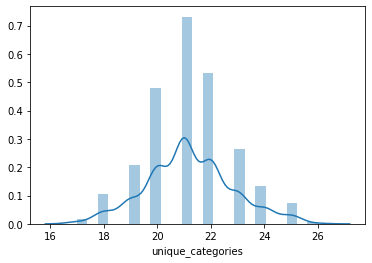

In [15]:
sns.distplot(users_interactions.unique_categories);

In [16]:
users_with_enough_interactions = users_interactions.query('unique_categories > 4')['client_id']
users_with_enough_interactions

0         1
1         2
2         3
3         4
4         5
       ... 
995     996
996     997
997     998
998     999
999    1000
Name: client_id, Length: 1000, dtype: int64

In [17]:
print(f'Всего пользователей: {users_interactions.shape[0]}')
print(f'Пользователей по крайней мере с 5 взаимодействиями: {users_with_enough_interactions.shape[0]}')

Всего пользователей: 1000
Пользователей по крайней мере с 5 взаимодействиями: 1000


Получаем, что пользователей меньше, чем с 5 взаимодействиями нет.

### Нормализация

В качестве нормализации воспользуемся MinMaxScaler.

In [18]:
data = data.assign(purchase_normalize = (data.purchase_count - data.purchase_count.min()) / (data.purchase_count.max() - data.purchase_count.min()))
data.head()

,client_id,product_category,purchase_count,purchase_normalize
0,1,10,18,0.042607
1,1,11,14,0.032581
2,1,13,23,0.055138
3,1,14,19,0.045113
4,1,16,10,0.022556


### Разбиение выборки на тренировочную и тестовую

Произведем разбиение выборки на обучение и контроль по времени. Перед этим возьмем последнее время взаимодействия пары client_id и product_category.

In [19]:
transactions_last_date = transactions_part \
    .groupby(['client_id', 'product_category'], as_index=False) \
    .date \
    .last()
transactions_last_date.head()

,client_id,product_category,date
0,1,10,2020-12-22 02:33:13
1,1,11,2020-12-22 10:20:44
2,1,13,2020-12-29 09:07:06
3,1,14,2020-12-31 06:49:11
4,1,16,2020-12-29 03:38:07


In [20]:
data = data \
    .merge(transactions_last_date, on=['client_id', 'product_category']) \
    .rename(columns={'date': 'last_date'})
data.head()

,client_id,product_category,purchase_count,purchase_normalize,last_date
0,1,10,18,0.042607,2020-12-22 02:33:13
1,1,11,14,0.032581,2020-12-22 10:20:44
2,1,13,23,0.055138,2020-12-29 09:07:06
3,1,14,19,0.045113,2020-12-31 06:49:11
4,1,16,10,0.022556,2020-12-29 03:38:07


In [31]:
split_date = '2020-12-30'
data_train = data.query('last_date < @split_date').copy()
data_test = data.query('last_date >= @split_date').copy()

print(f'Всего взаимодействий: {data.shape[0]}')
print(f'Доля взаимодействий в тренировочной выборке: {round(data_train.shape[0] / data.shape[0], 1)} ({data_train.shape[0]})')
print(f'Доля взаимодействий в тестовой выборке: {round(data_test.shape[0] / data.shape[0], 1)} ({data_test.shape[0]})')

Всего взаимодействий: 21201
Доля взаимодействий в тренировочной выборке: 0.8 (17658)
Доля взаимодействий в тестовой выборке: 0.2 (3543)


Для удобства подсчета качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков

In [47]:
data_true = (
    data_train
    .groupby('client_id')['product_category'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'product_category': 'true_train'})
    .set_index('client_id')
)

data_true['true_test'] = (
    data_test
    .groupby('client_id')['product_category'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
# data_true.loc[pd.isnull(data_true.true_test), 'true_test'] = [
#     list() for x in range(len(data_true.loc[pd.isnull(data_true.true_test), 'true_test']))]

data_true.head(1)

,true_train,true_test
client_id,,
1,"[10, 11, 13, 16, 17, 18, 19, 2, 20, 21, 4, 6, ...","[14, 28, 5, 9]"


Заполним пропуски пустыми списками.

In [52]:
data_true.loc[pd.isnull(data_true.true_test), 'true_test'] = [
    list() for x in range(len(data_true.loc[pd.isnull(data_true.true_test), 'true_test']))]

In [53]:
data_true.head(1)

,true_train,true_test
client_id,,
1,"[10, 11, 13, 16, 17, 18, 19, 2, 20, 21, 4, 6, ...","[14, 28, 5, 9]"


In [21]:
data_matrix = pd.pivot_table(data, index='client_id', columns='product_category', values='purchase_count')
data_matrix.head()

product_category,1,10,11,12,13,14,15,16,17,18,...,27,28,29,3,4,5,6,7,8,9
client_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,18.0,14.0,NaN,23.0,19.0,NaN,10.0,6.0,17.0,...,NaN,111.0,NaN,NaN,12.0,152.0,390.0,27.0,25.0,20.0
2,30.0,21.0,19.0,NaN,19.0,18.0,44.0,9.0,11.0,8.0,...,NaN,120.0,NaN,41.0,5.0,136.0,303.0,13.0,14.0,26.0
3,39.0,16.0,26.0,NaN,17.0,17.0,43.0,8.0,10.0,8.0,...,NaN,119.0,NaN,37.0,12.0,159.0,308.0,30.0,18.0,22.0
4,NaN,20.0,17.0,NaN,11.0,15.0,NaN,9.0,3.0,17.0,...,NaN,100.0,12.0,NaN,6.0,118.0,371.0,18.0,28.0,21.0
5,45.0,34.0,24.0,NaN,26.0,29.0,NaN,7.0,11.0,11.0,...,NaN,103.0,NaN,44.0,NaN,155.0,392.0,28.0,22.0,27.0


In [ ]:
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx